In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score

In [21]:
train = pd.read_csv("train_B.csv")
test = pd.read_csv("test_B.csv")

In [22]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train_reducido = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test_reducido = pd.concat([test_reducido_udp, test_reducido_tcp])

In [4]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

In [23]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train_reducido = train_reducido.drop(columns=['category'])
y_train_reducido = train_reducido['category']

# Separar características y etiquetas para conjunto de prueba
X_test_reducido = test_reducido.drop(columns=['category'])
y_test_reducido = test_reducido['category']

In [24]:
column_names = X_train_reducido.columns

#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train_reducido = pd.DataFrame(norm.fit_transform(X_train_reducido), columns=column_names)
X_test_reducido = pd.DataFrame(norm.transform(X_test_reducido), columns=column_names)


In [25]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(27.1)}
Best Cross Validation Score: 0.6424807815502883
Test Score: 0.646875


In [26]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test_reducido)
print('Precision en test: ', accuracy_score(y_test_reducido, y_pred))

Precision en test:  0.646875


In [27]:
import time

SVM = svm.SVC(kernel='rbf', C=27.1 ,gamma='scale')

start=time.time()
SVM.fit(X_train_reducido, y_train_reducido)
stop=time.time()

tiempo = stop - start

print(f"Tiempo de entrenamiento SVM: {tiempo}s")
print(f'Train accuracy : {SVM.score(X_train_reducido, y_train_reducido): .3f}')


start2=time.time()
print(f'Test accuracy : {SVM.score(X_test_reducido, y_test_reducido): .3f}')
stop2=time.time()

tiempo2 = stop2 - start2
print(f"Tiempo de prediccion (Test) SVM: {tiempo2}s")

Tiempo de entrenamiento SVM: 0.04051351547241211s
Train accuracy :  0.759
Test accuracy :  0.647
Tiempo de prediccion (Test) SVM: 0.01358938217163086s


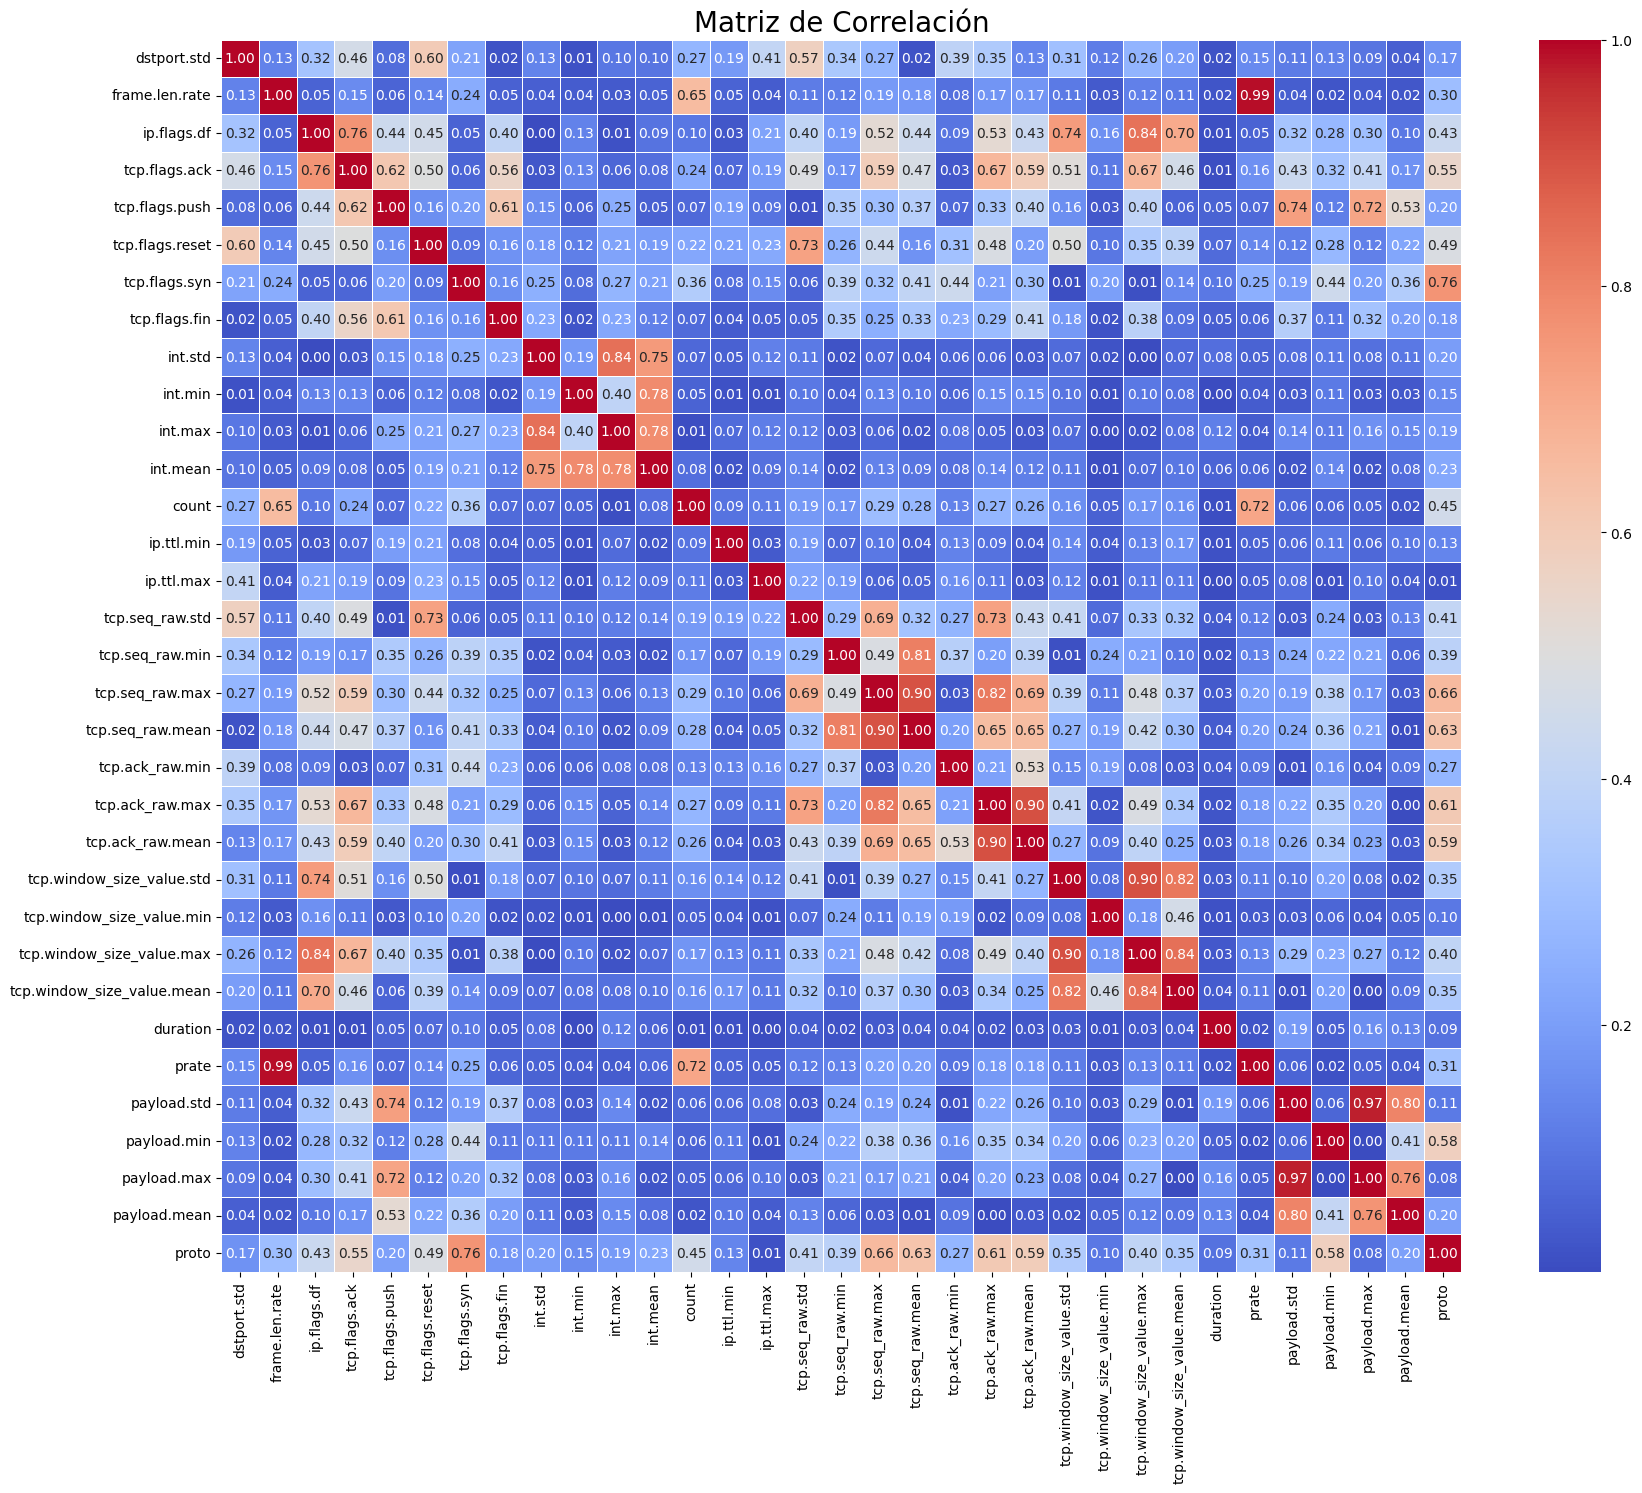

In [28]:
corr_matrix = X_train_reducido.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()

In [29]:
def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns. Sets cannot contain duplicated elements
    col_corr = set()
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        # check with other features (Not with itself)
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value

                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [30]:
corr_features = correlation(X_train_reducido, 0.78)
len(set(corr_features))

0.8424994838749348 int.max int.std
0.7827272187378232 int.mean int.min
0.7808933725340748 int.mean int.max
0.8116666613274177 tcp.seq_raw.mean tcp.seq_raw.min
0.9008522190277712 tcp.seq_raw.mean tcp.seq_raw.max
0.8231503446401485 tcp.ack_raw.max tcp.seq_raw.max
0.9038036980318623 tcp.ack_raw.mean tcp.ack_raw.max
0.8360235475200547 tcp.window_size_value.max ip.flags.df
0.9025022228827219 tcp.window_size_value.max tcp.window_size_value.std
0.8249083385342003 tcp.window_size_value.mean tcp.window_size_value.std
0.8432644515857678 tcp.window_size_value.mean tcp.window_size_value.max
0.989384138965096 prate frame.len.rate
0.9743135329973276 payload.max payload.std
0.7994477530027312 payload.mean payload.std


11

In [31]:
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.80,
    missing_values="raise",
    selection_method="model_performance",
    estimator=SVM,
    scoring="accuracy",
    cv=5,
)

sel.fit(X_train_reducido, y_train_reducido)

SmartCorrelatedSelection(cv=5, estimator=SVC(C=27.1), missing_values='raise',
                         scoring='accuracy',
                         selection_method='model_performance')

In [32]:
sel.correlated_feature_sets_

[{'frame.len.rate', 'prate'},
 {'int.max', 'int.std'},
 {'ip.flags.df', 'tcp.window_size_value.max'},
 {'payload.max', 'payload.std'},
 {'tcp.ack_raw.max', 'tcp.ack_raw.mean', 'tcp.seq_raw.max'},
 {'tcp.seq_raw.mean', 'tcp.seq_raw.min'},
 {'tcp.window_size_value.mean', 'tcp.window_size_value.std'}]

In [33]:
corr_features = sel.features_to_drop_
sel.features_to_drop_

['prate',
 'int.std',
 'ip.flags.df',
 'payload.std',
 'tcp.ack_raw.max',
 'tcp.ack_raw.mean',
 'tcp.seq_raw.min',
 'tcp.window_size_value.std']

In [34]:
X_train_reducido.drop(columns=corr_features, axis=1, inplace=True)
X_test_reducido.drop(columns=corr_features, axis=1, inplace=True)

X_train_reducido.shape, X_test_reducido.shape

((1119, 25), (320, 25))

In [17]:
# Ver los valores NaN en cada columna de X_train
nan_counts = X_train_reducido.isna().sum()

# Mostrar las columnas que tienen valores NaN
print(nan_counts[nan_counts > 0])

Series([], dtype: int64)


In [18]:
# select second group of correlated features
group = sel.correlated_feature_sets_[0]

# build SVM with cross validation for
# each feature

for f in group:
    
    model = cross_validate(
        SVM,
        X_train_reducido[f].to_frame(),
        y_train_reducido,
        cv=3,
        return_estimator=False,
        scoring='accuracy',
    )

    print(f, model["test_score"].mean())

KeyError: 'prate'

In [35]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(9.1)}
Best Cross Validation Score: 0.6397901985906469
Test Score: 0.653125


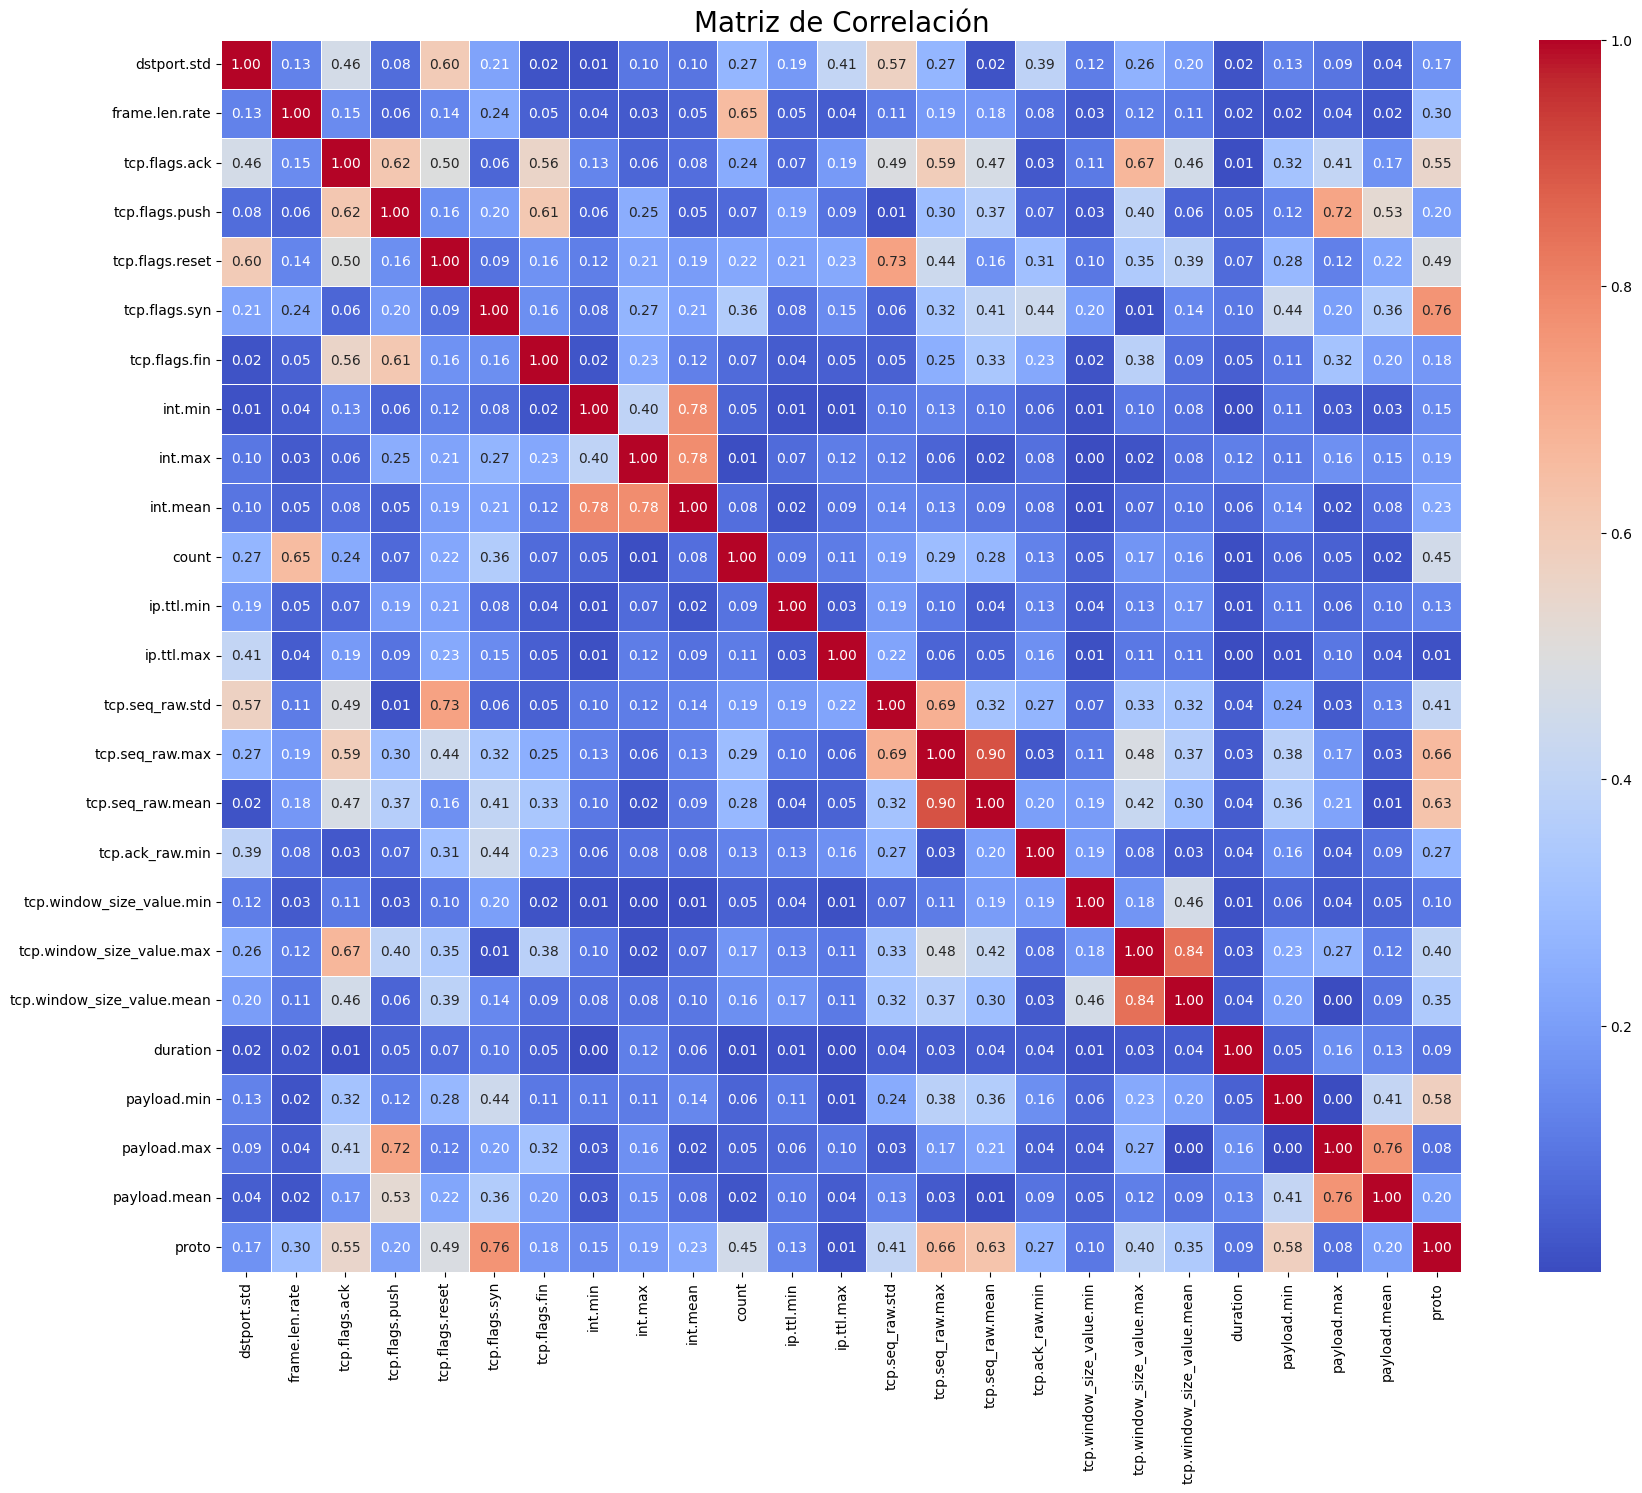

In [36]:
corr_matrix = X_train_reducido.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()

In [37]:
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.78,
    missing_values="raise",
    selection_method="model_performance",
    estimator=SVM,
    scoring="accuracy",
    cv=5,
)

sel.fit(X_train_reducido, y_train_reducido)

SmartCorrelatedSelection(cv=5, estimator=SVC(), missing_values='raise',
                         scoring='accuracy',
                         selection_method='model_performance', threshold=0.78)

In [38]:
sel.correlated_feature_sets_

[{'int.max', 'int.mean'},
 {'tcp.seq_raw.max', 'tcp.seq_raw.mean'},
 {'tcp.window_size_value.max', 'tcp.window_size_value.mean'}]

In [39]:
corr_features = sel.features_to_drop_
sel.features_to_drop_

['int.mean', 'tcp.seq_raw.max', 'tcp.window_size_value.mean']

In [40]:
X_train_reducido.drop(columns=corr_features, axis=1, inplace=True)
X_test_reducido.drop(columns=corr_features, axis=1, inplace=True)

X_train_reducido.shape, X_test_reducido.shape

((1119, 22), (320, 22))

In [41]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(10.1)}
Best Cross Validation Score: 0.6389013452914798
Test Score: 0.665625


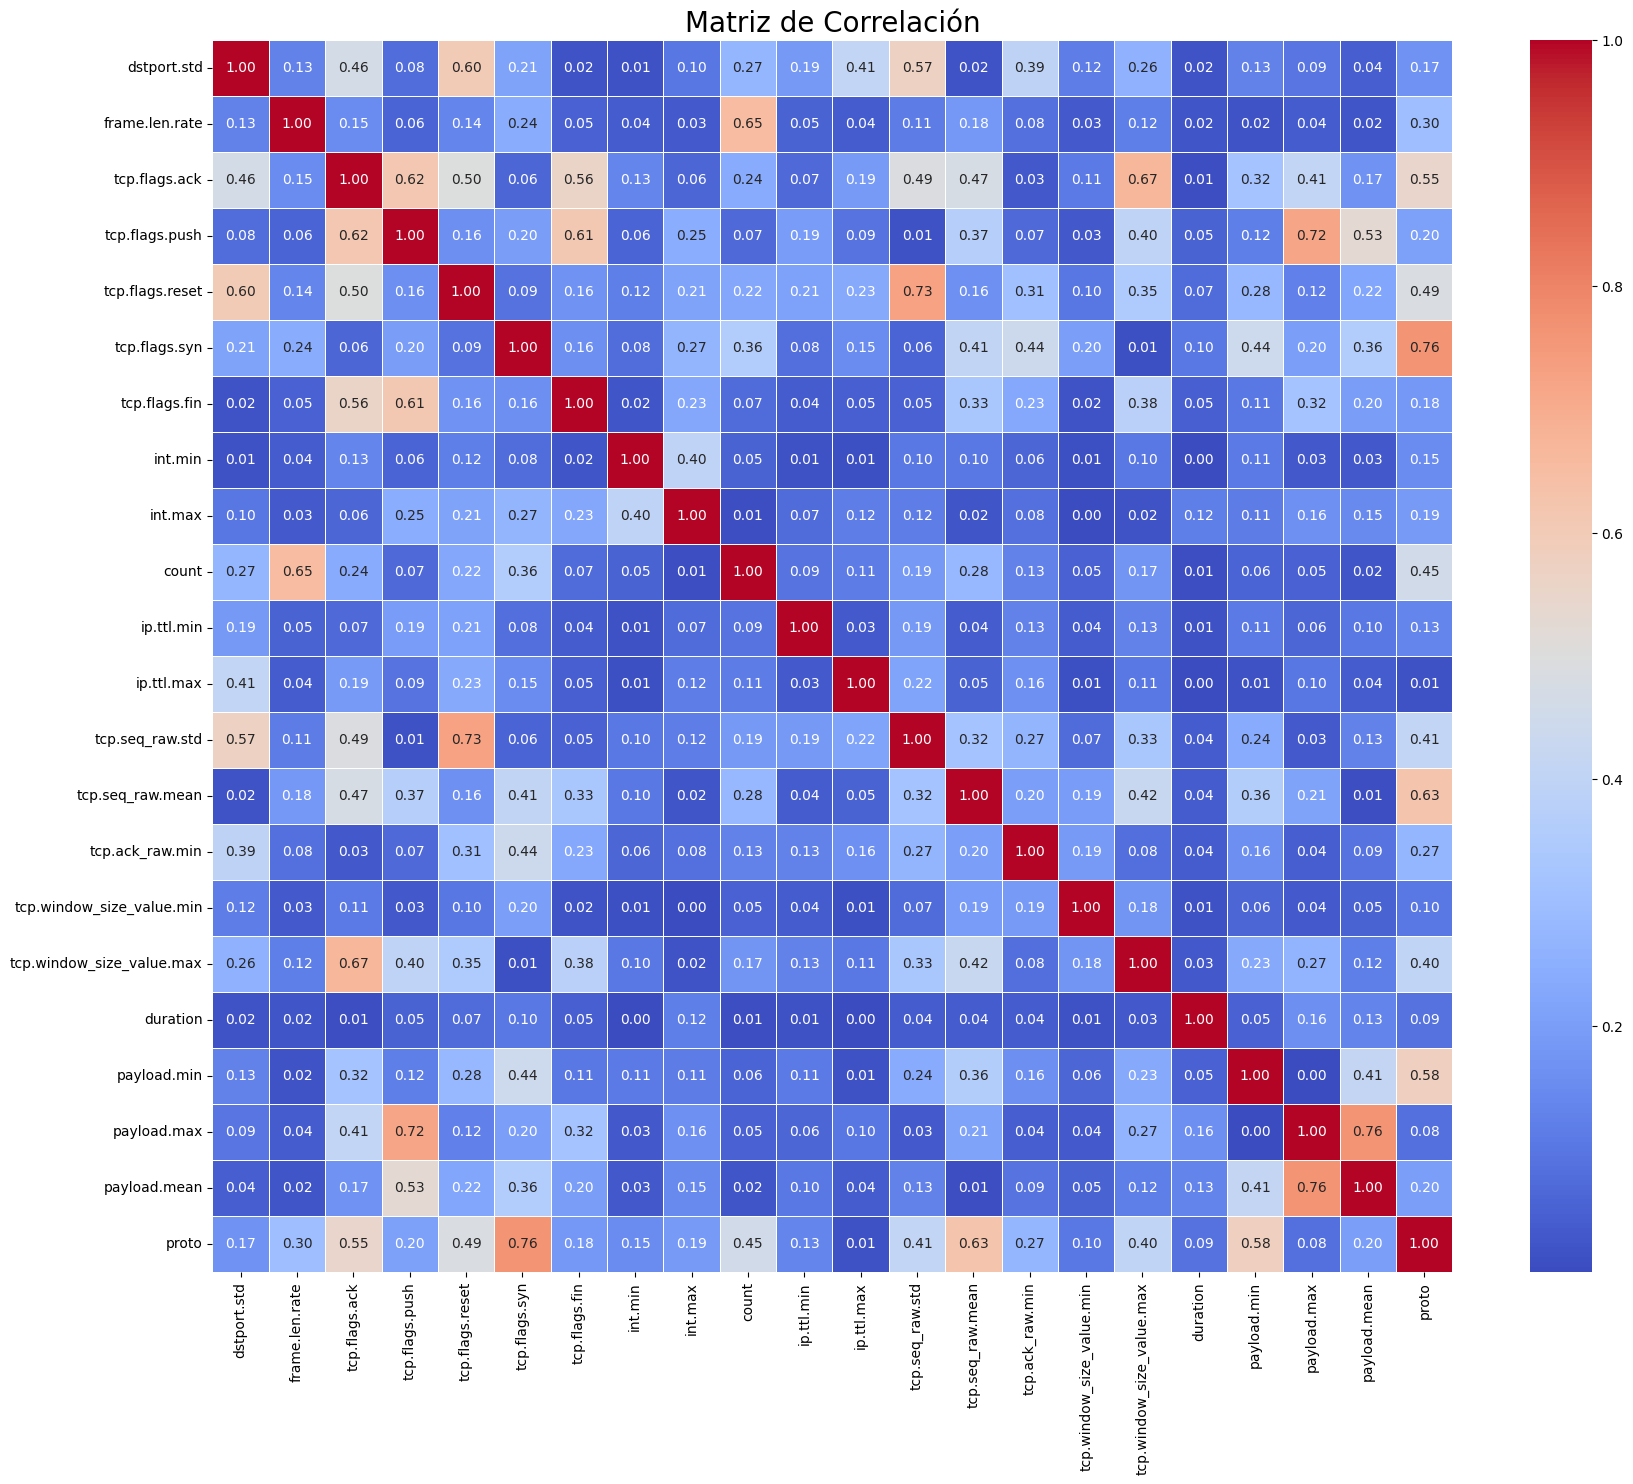

In [42]:
corr_matrix = X_train_reducido.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()

### NOT USED

In [27]:
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.78,
    missing_values="raise",
    selection_method="model_performance",
    estimator=SVM,
    scoring="accuracy",
    cv=5,
)

sel.fit(X_train_reducido, y_train_reducido)

SmartCorrelatedSelection(cv=5, estimator=SVC(), missing_values='raise',
                         scoring='accuracy',
                         selection_method='model_performance', threshold=0.78)

In [28]:
sel.correlated_feature_sets_

[{'tcp.seq_raw.mean', 'tcp.seq_raw.min'}]

In [29]:
corr_features = sel.features_to_drop_
sel.features_to_drop_

['tcp.seq_raw.min']

In [30]:
X_train_reducido.drop(columns=corr_features, axis=1, inplace=True)
X_test_reducido.drop(columns=corr_features, axis=1, inplace=True)

X_train_reducido.shape, X_test_reducido.shape

((1119, 22), (320, 22))

In [31]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(38.1)}
Best Cross Validation Score: 0.629091928251121
Test Score: 0.6625


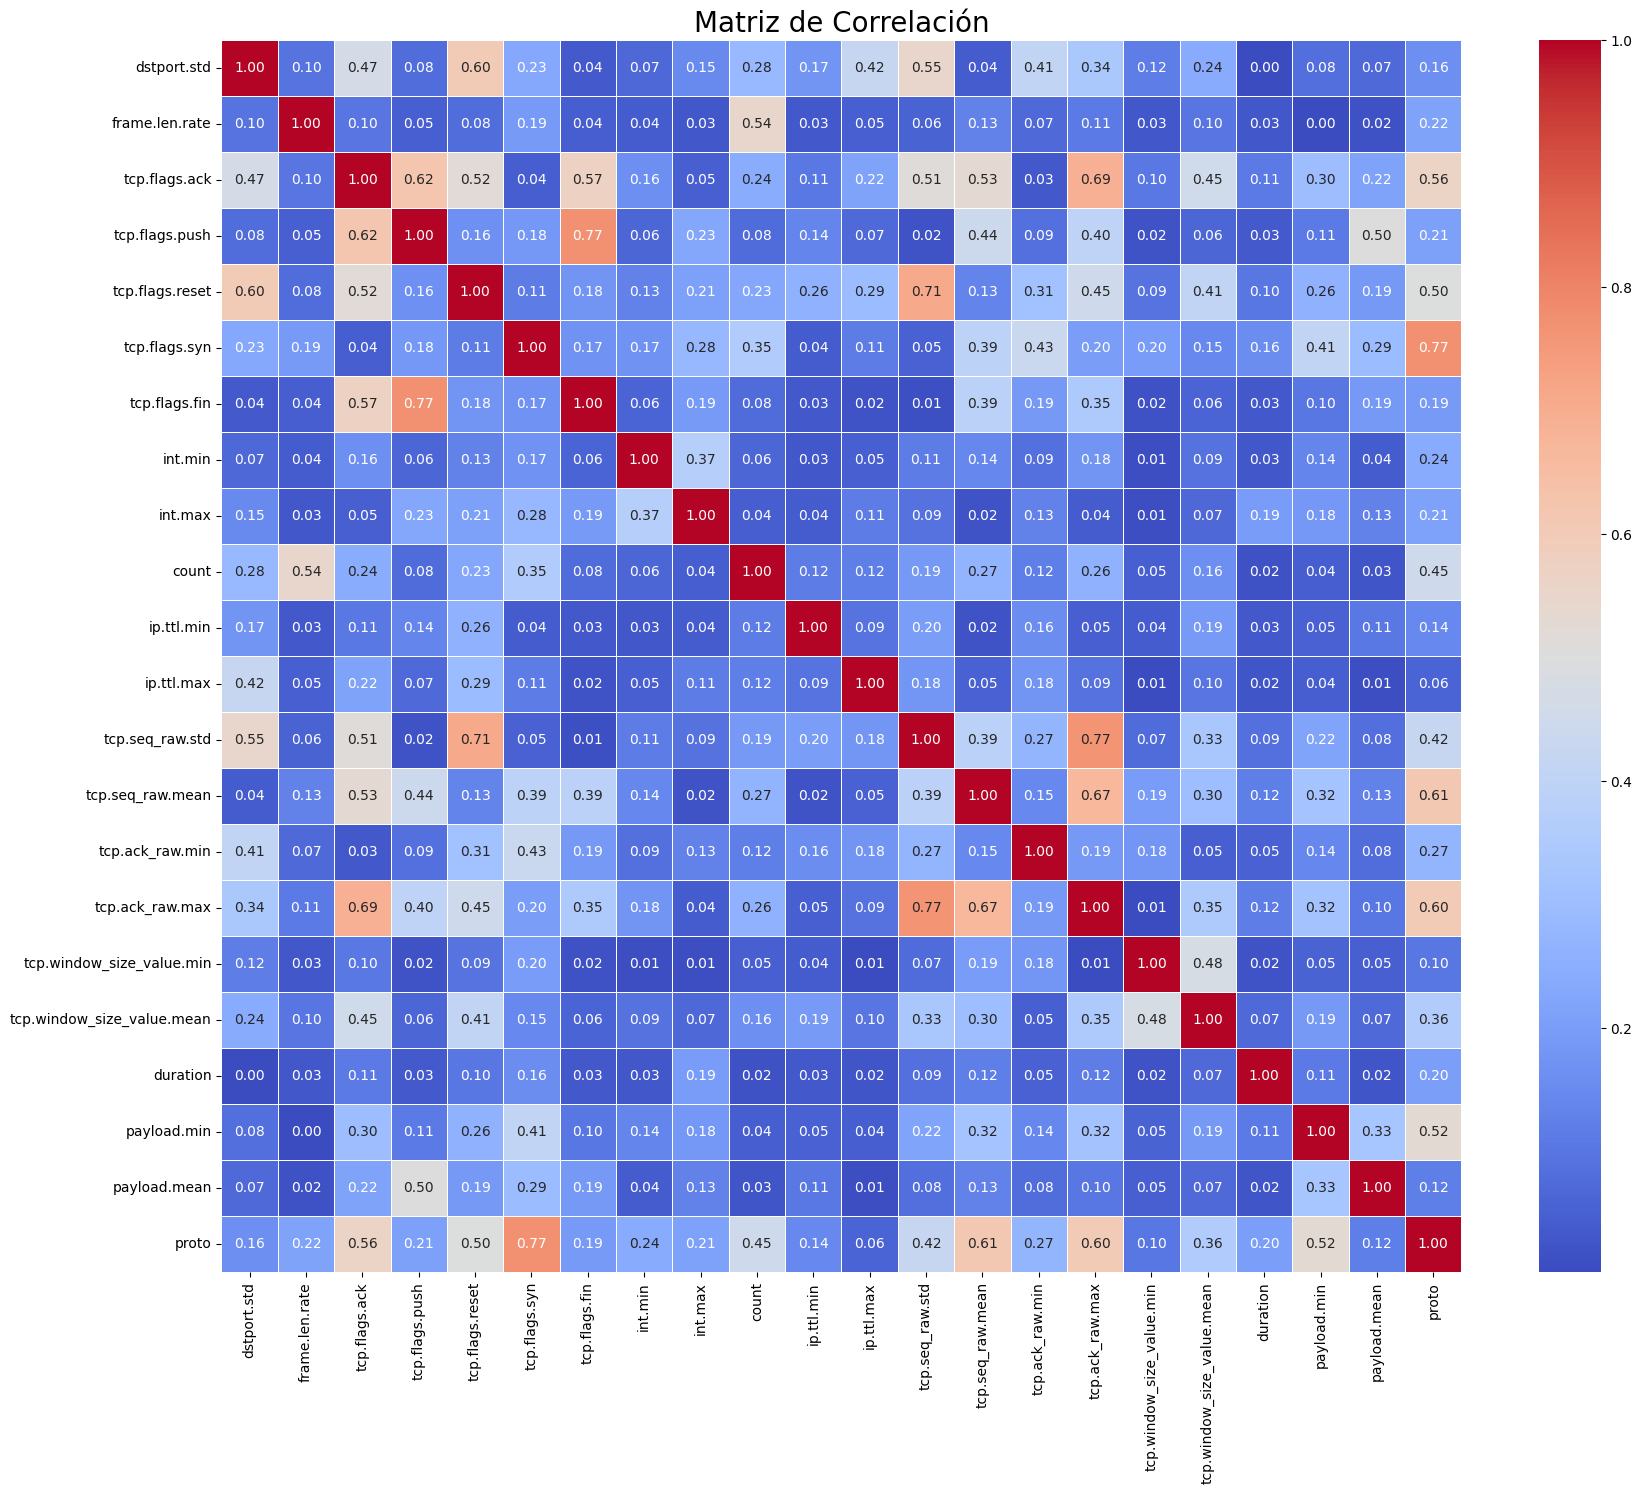

In [32]:
corr_matrix = X_train_reducido.corr().abs()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()

In [43]:
X_train_reducido = X_train_reducido.reset_index(drop=True)
y_train_reducido = y_train_reducido.reset_index(drop=True)
train = pd.concat([X_train_reducido, y_train_reducido], axis=1)

X_test_reducido = X_test_reducido.reset_index(drop=True)
y_test_reducido = y_test_reducido.reset_index(drop=True)
test = pd.concat([X_test_reducido, y_test_reducido], axis=1)

In [44]:

train.to_csv('train_C.csv', index=False)
test.to_csv('test_C.csv', index=False)